In [155]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import awkward as ak

In [156]:
#Funzioni utili
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [157]:
Vt = -1.3 #V
Q_max = -30 #pC carica massima per considerare il segnale (Minima in modulo)
Q_min = -1000 #pC tolgo i cosmici

In [236]:
channel = 5 #Canale di cui si effettua l'analisi
PATH = '../Dati/21-03/Run_ch5_Cs_Measurements_Only_3_21_2024.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../Dati/Noises/ch' + str(channel) + '.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore

In [237]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]

T_noises = np.array([0, 0, 213, 0, 1868, 1758, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #Da sistemare e tenere aggiornato
                                                                              #durata delle prese dati di noise

TCs = 312  #s, tempo presa dati con sorgente  Da ch5 del 21/03

rateCs = evCsT / TCs
rateN = evNT / T_noises[channel]

print("# eventi di background = " + str(evNT))
print("# eventi con sorgente = " + str(evCsT))
print("rate con sorgente = " + str(round(rateCs)) + "Hz")
print("rate di background = " + str(round(rateN)) + "Hz")

# eventi di background = 300000
# eventi con sorgente = 100000
rate con sorgente = 321Hz
rate di background = 171Hz


In [238]:
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 5 = 87784
#Noise ripulita su ch 5 = 223388


In [239]:
#Aggiorno i tempi di presa dati, che vanno rinormalizzati al numero di eventi rimasti,
#sia per il segnale che per la noise: il tempo "efficace" è dato dal tempo originale 
#riscalato alla frazione di eventi rimasti dopo la pulizia

TCs_eff = TCs * len(chargeCs) / evCsT
TN_eff  = T_noises[channel]  * len(chargeN)  / evNT

print("Tempo di presa dati effettivo con sorgente = " + str(round(TCs_eff)) + "s")
print("Tempo di presa dati effettivo di background = " + str(round(TN_eff)) + "s")

print ("Rate Cs eff = " + str(round(len(chargeCs) / TCs_eff)) + "Hz")
print ("Rate N eff = " + str(round(len(chargeN) / TN_eff)) + "Hz")

Tempo di presa dati effettivo con sorgente = 274s
Tempo di presa dati effettivo di background = 1309s
Rate Cs eff = 321Hz
Rate N eff = 171Hz


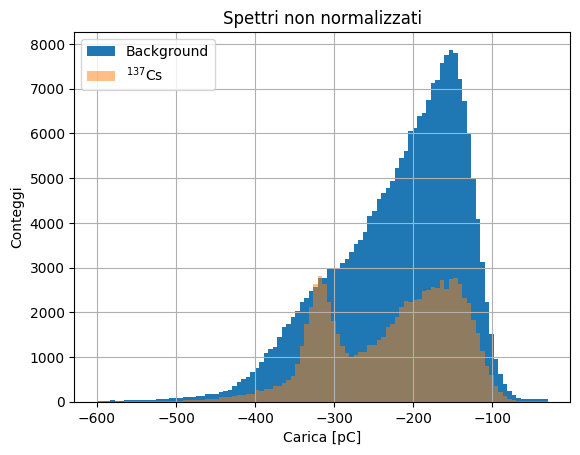

In [240]:
bin = 100 #Binnaggio scelto?

binN , edgeN , _= plt.hist(chargeN, bins=bin, range=(-600, Q_max), density = False, label = "Background")
binCs, edgeCs, _ = plt.hist(chargeCs, bins=bin, range=(-600, Q_max), density = False, label = r'$^{137}$Cs', alpha = 0.5)

plt.title("Spettri non normalizzati")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
plt.show()

1.3634156213120439


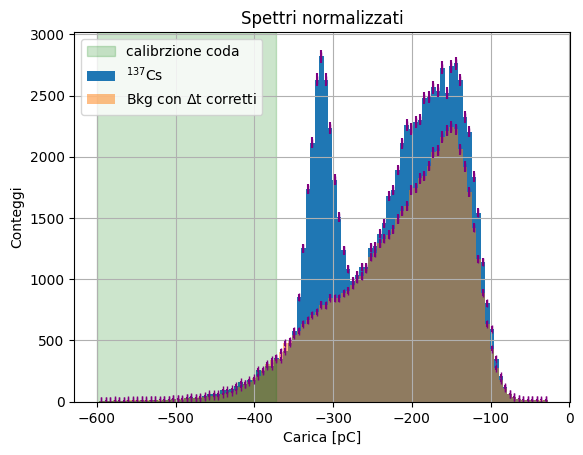

In [257]:
#Rinormalizzazione
avg_coda = ( binCs / (binN / TN_eff * TCs_eff))[:int(bin * 40 / 100)].mean()
print(avg_coda)
binN_Ren = binN / TN_eff * TCs_eff * avg_coda #Moltiplicando per 1.5 viene molto meglio... mhhh

wdt = edgeN[1] - edgeN[0]
trash = plt.bar(edgeN[1:], binCs, width=wdt, label = r'$^{137}$Cs')
trash = plt.bar(edgeN[1:], binN_Ren, width=wdt, label = r'Bkg con $\Delta$t corretti', alpha = 0.5)

errCs = np.sqrt(binCs)
errN  = np.sqrt(binN_Ren)

trash = plt.errorbar(edgeN[1:], binN_Ren, errN, color='purple', fmt='|')
trash = plt.errorbar(edgeCs[1:], binCs, errCs, color='purple', fmt='|')

plt.axvspan(edgeN[0], edgeN[int(bin * 40 / 100)], color='green', alpha=0.2, label = "calibrzione coda")


plt.title("Spettri normalizzati")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
plt.savefig("../Fig/Spettri_Normalizzati_.png")
plt.show()



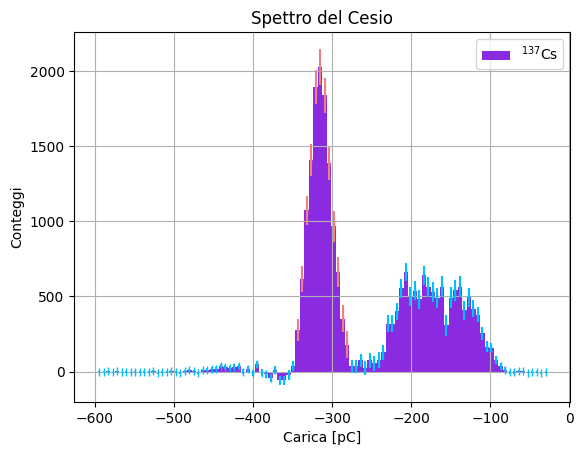

In [272]:
wdt = edgeN[1] - edgeN[0]
binSign = binCs - binN_Ren

trash = plt.bar(edgeN[1:],binSign,width = wdt, label = r'$^{137}$Cs', color = "blueviolet")

err = np.sqrt(binCs  + binN_Ren )

#Determinazione del picco
peak_cntr = np.argmax(binSign)
peak_ledge = peak_cntr - 5
peak_redge = peak_cntr + 7


trash = plt.errorbar(edgeN[1:peak_ledge+1], binSign[:peak_ledge], err[:peak_ledge], color='deepskyblue', fmt='|')
trash = plt.errorbar(edgeN[peak_redge+1:], binSign[peak_redge:], err[peak_redge:], color='deepskyblue', fmt='|')

trash = plt.errorbar(edgeN[peak_ledge+1:peak_redge+1], 
                     binSign[peak_ledge:peak_redge], 
                     2*err[peak_ledge:peak_redge], 
                     color='lightcoral', fmt='|')



plt.title("Spettro del Cesio")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
plt.savefig("../Fig/Spettro_Cs.png")
plt.show()


Valor medio = -320.1pC
Dev std = 13.9pC


/var/folders/0y/k6xzqpg904jd8jnjbgq30b4w0000gn/T/ipykernel_68037/2691465978.py:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_values, gaussian(x_values, *popt), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt), ls = "-.")


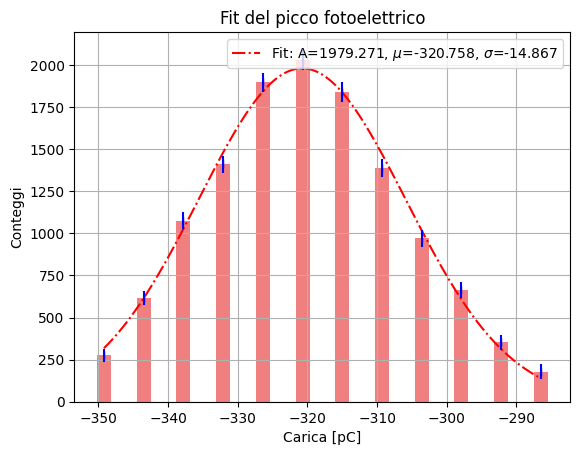

Chi-quadro: 11.499843183864337
dof: 12


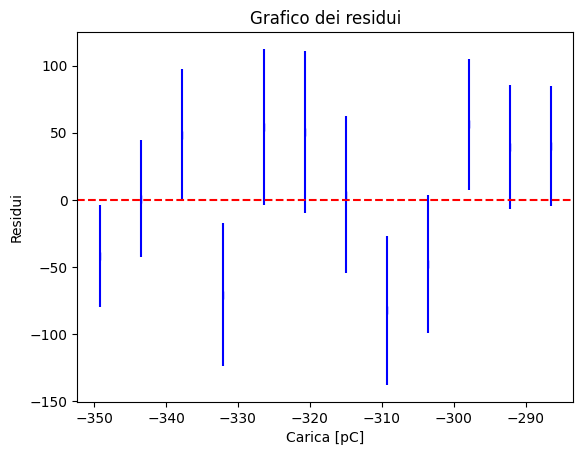

In [275]:
from scipy.optimize import curve_fit
#Isolo la parte di spettro legata al fotoelettrico
edge_photo=edgeN[peak_ledge:peak_redge]
counts_photo=binSign[peak_ledge:peak_redge]
err_photo=err[peak_ledge:peak_redge]

#bin_centers = (edge_photo[:-1] + edge_photo[1:]) / 2
bin_centers=edge_photo
# Calcoliamo il valore rappresentativo pesato dai conteggi di ciascun bin
weighted_values = bin_centers * counts_photo

# Calcoliamo la media pesata
weighted_mean = np.sum(weighted_values) / np.sum(counts_photo)

# Calcoliamo la deviazione standard pesata
weighted_std = np.sqrt(np.sum(counts_photo * (bin_centers - weighted_mean)**2) / np.sum(counts_photo))

print("Valor medio = " + str(round(weighted_mean, 1)) + "pC")
print("Dev std = " + str(round(weighted_std, 1)) + "pC")



# Facciamo il fit della gaussiana ai dati
popt, pcov = curve_fit(gaussian, bin_centers, counts_photo, p0=[1, weighted_mean, weighted_std], sigma=err_photo,
                        maxfev = 5000)

# Plot dell'istogramma e della curva di fit
plt.bar(edge_photo,counts_photo,width=2, color = "lightcoral")
x_values=np.linspace(np.min(edge_photo), np.max(edge_photo), 200)
plt.plot(x_values, gaussian(x_values, *popt), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt), ls = "-.")
plt.errorbar(edge_photo, counts_photo, err_photo, color='blue', fmt='|')
plt.legend()
plt.xlabel('Carica [pC]')
plt.ylabel('Conteggi')
plt.title("Fit del picco fotoelettrico")
plt.grid()
plt.savefig("../Fig/Picco_Cs.png")
plt.show()


#fare chi quadro e residui
valori_previsti = gaussian(edge_photo, *popt)

# 2. Calcola il chi-quadro
chi_quadro = np.sum(((counts_photo - valori_previsti) / err_photo)**2)

print("Chi-quadro:", chi_quadro)
print("dof:", np.size(counts_photo))

# 3. Calcola i residui
residui = counts_photo - valori_previsti

# 4. Traccia il grafico dei residui
plt.errorbar(edge_photo, residui, err_photo,color='blue', fmt='|')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Carica [pC]')
plt.ylabel('Residui')
plt.title('Grafico dei residui')
plt.show()

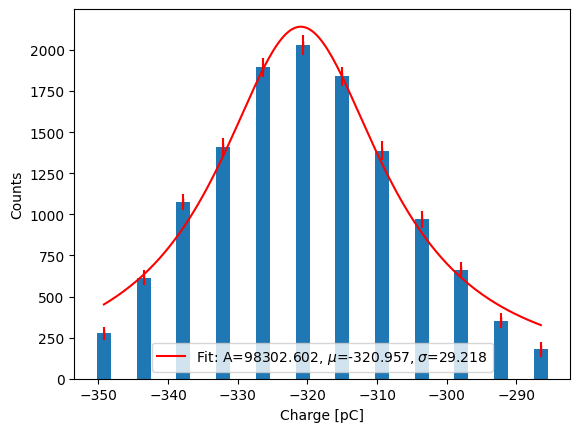

In [274]:
def lorentzian(x, A, x0, L):
    return A / (2 * np.pi) * L / ((x - x0)**2 + (0.5 * L)**2)


popt, pcov = curve_fit(lorentzian, bin_centers, counts_photo, p0=[1, weighted_mean, weighted_std], sigma=err_photo)

# Plot dell'istogramma e della curva di fit
#plt.hist(dati, bins=30, density=True, alpha=0.5, color='b', label='Istogramma dei dati')
plt.bar(edge_photo,counts_photo,width=2)
x_values=np.linspace(np.min(edge_photo), np.max(edge_photo), 200)
plt.plot(x_values, lorentzian(x_values, *popt), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt))
plt.errorbar(edge_photo, counts_photo, err_photo, color='red', fmt='|')
plt.legend()
plt.xlabel('Charge [pC]')
plt.ylabel('Counts')
plt.show()

Chi-quadro: 100.79275807249326
dof: 10


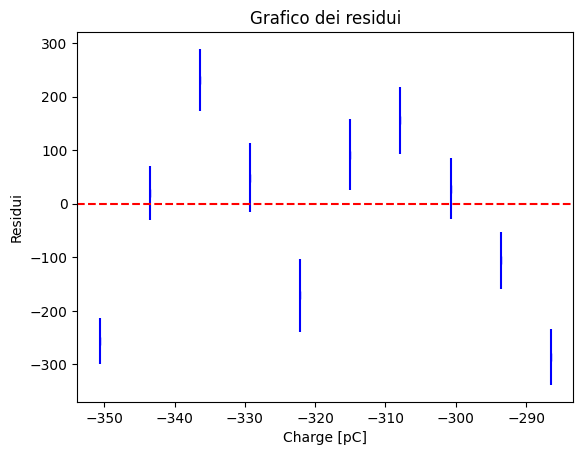

In [170]:
#fare chi quadro e residui
valori_previsti = lorentzian(edge_photo, *popt)

# 2. Calcola il chi-quadro
chi_quadro = np.sum(((counts_photo - valori_previsti) / err_photo)**2)

print("Chi-quadro:", chi_quadro)
print("dof:", np.size(counts_photo))

# 3. Calcola i residui
residui = counts_photo - valori_previsti

# 4. Traccia il grafico dei residui
plt.errorbar(edge_photo, residui, err_photo,color='blue', fmt='|')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Charge [pC]')
plt.ylabel('Residui')
plt.title('Grafico dei residui')
plt.show()

In [200]:
(binCs / binN_Ren)[:32].mean()

1.3650064918479345